In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
from gfloat import *
from gfloat.formats import format_info_ocp_e5m2

# Abbreviate RoundMode printing just for this notebook, for figure legends
if "RoundMode__str__" not in locals():
    RoundMode__str__ = RoundMode.__str__
    RoundMode.__str__ = lambda x: RoundMode__str__(x).replace(
        "RoundMode.Stochastic", "SR"
    )

    assert str(RoundMode.StochasticFast) == "SRFast"


def longstr(rnd):
    if rnd == RoundMode.StochasticFast:
        return r"SRFast ($x - \lfloor x \rfloor > (SRBits + 0.5) \times 2^{-nbits}$)"
    elif rnd == RoundMode.StochasticFastest:
        return r"SRFastest ($x - \lfloor x \rfloor > SRBits \times 2^{-nbits}$)"
    elif rnd == RoundMode.Stochastic:
        return r"SR ($RTNE(x - \lfloor x \rfloor, nbits) > SRBits \times 2^{-nbits}$)"
    else:
        raise ValueError(f"Unknown rounding mode {rnd}")


mode_colors = {
    RoundMode.TiesToEven: ("pink", "red"),
    RoundMode.StochasticFastest: ("bisque", "orange"),
    RoundMode.StochasticFast: ("lightblue", "blue"),
    RoundMode.Stochastic: ("#ada", "green"),
    RoundMode.StochasticOdd: ("#faf", "purple"),
}


def lollipops(ax, xs, ys, key, label):
    colors = mode_colors[key]
    ax.plot(
        [xs, xs],
        [xs, ys],
        label=None,
        color=colors[0],
        markeredgecolor="k",
        markersize=2,
        linestyle="-",
    )
    ax.plot(
        xs, ys, label=label, color=colors[1], marker=".", markersize=3, linestyle=""
    )

# Stochastic rounding

This notebook does some simple experiments with stochastic rounding.

Let's see examples of stochastic rounding and the default round-to-nearest for 
some input values in an 8-bit float range. 

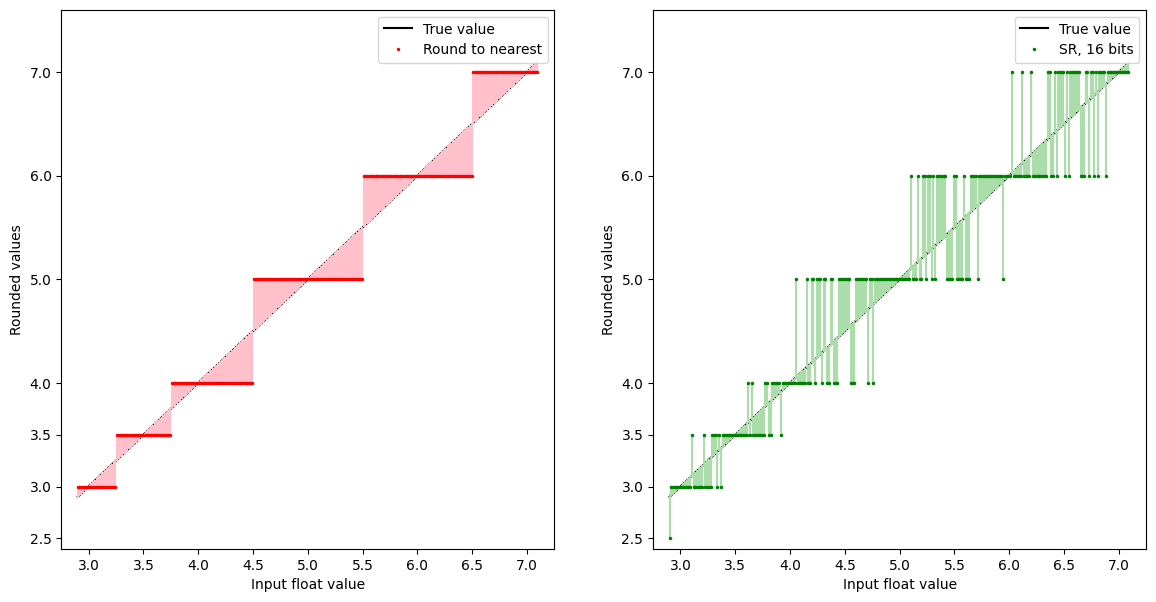

In [2]:
fi = format_info_ocp_e5m2  # A common P3 format

vs = np.arange(2.9, 7.1, step=1 / 64)

# Round to nearest
rn = round_ndarray(fi, vs)

# Stochastic rounding
np.random.seed(1)
srnumbits = 16
srbits = np.random.randint(0, 2**srnumbits, len(vs))
rvs = round_ndarray(
    fi, vs, RoundMode.Stochastic, sat=False, srbits=srbits, srnumbits=srnumbits
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
for ax in axs:
    ax.plot(vs, vs, label="True value", color="k")

    if ax == axs[0]:
        lollipops(ax, vs, rn, key=RoundMode.TiesToEven, label="Round to nearest")
    else:
        lollipops(ax, vs, rvs, key=RoundMode.Stochastic, label=f"SR, {srnumbits} bits")

    ax.set_xlabel("Input float value")
    ax.set_ylabel(f"Rounded values")
    ax.set_yticks(np.unique(rvs))
    ax.set_xlim(2.75, 7.25)
    ax.set_ylim(2.4, 7.6)
    ax.legend()

The black $Y=X$ curve plots the input real value, the red curve shows that value 
rounded to the nearest representable value in the chosen float format, 
and the grey curve shows stochastic rounding, again to a nearest representable value,
but randomly up or down depending how close the input value is to the next highest 
and lowest representable values.

In order to get a better idea of the behaviour, we will change the plot to show the 
average rounded value at each input real value.  At 16 bits of randomness, 
this almost appears too good to be true:

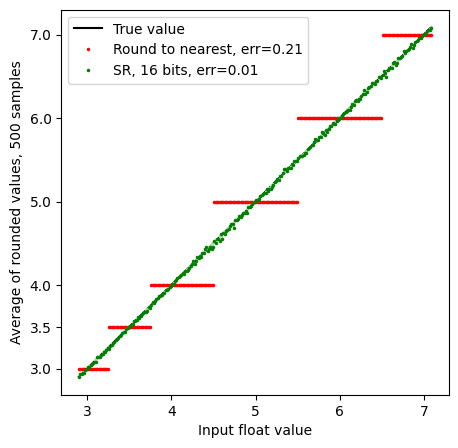

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(vs, vs, label="True value", color="k", marker="None", linestyle="-")

# Compute mean absolute error
err_rn = np.abs(rn - vs).mean()
ax.plot(
    vs,
    rn,
    label=f"Round to nearest, err={err_rn:.2f}",
    color="red",
    markersize=3,
    linestyle="",
    marker=".",
)

# Stochastic rounding, multiple samples
srnumbits = 16
nsamples = 500
srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

rvs = round_ndarray(
    fi,
    vs[np.newaxis, :],
    RoundMode.Stochastic,
    sat=False,
    srbits=srbits,
    srnumbits=srnumbits,
)

rvmean = rvs.mean(axis=0)
err = np.abs(rvmean - vs).mean()
lollipops(
    ax,
    vs,
    rvmean,
    key=RoundMode.Stochastic,
    label=f"SR, {srnumbits} bits, err={err:.2f}",
)

ax.set_xlabel("Input float value")
ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
ax.set_yticks(np.unique(rn))
ax.legend()
None

The green line is pretty much on top of the true value (some small random 
deviations are evident), indicating that with 500 samples, 
the stochastically rounded value is on average very accurate.

Before we go further, let's zoom in a bit:

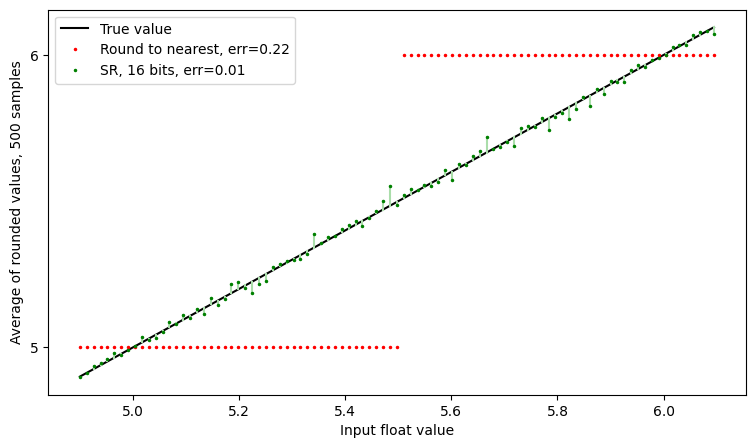

In [4]:
vs = np.arange(4.9, 6.1, 1 / 77)
# Round to nearest
rn = round_ndarray(fi, vs)
err_rn = np.abs(rn - vs).mean()

fig, ax = plt.subplots(1, 1, figsize=(9, 5))

ax.plot(vs, vs, label="True value", color="k")
ax.plot(
    vs,
    rn,
    label=f"Round to nearest, err={err_rn:.2f}",
    color="red",
    markersize=3,
    linestyle="",
    marker=".",
)

# Stochastic rounding
srnumbits = 16
nsamples = 500
srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

rvs = round_ndarray(
    fi,
    vs[np.newaxis, :],
    RoundMode.Stochastic,
    sat=False,
    srbits=srbits,
    srnumbits=srnumbits,
)
rvmean = rvs.mean(axis=0)
err = np.abs(rvmean - vs).mean()
lollipops(
    ax,
    vs,
    rvmean,
    label=f"SR, {srnumbits} bits, err={err:.2f}",
    key=RoundMode.Stochastic,
)

ax.set_xlabel("Input float value")
ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
ax.set_yticks(np.unique(rn))
ax.legend()
None

The random deviation is easier to see at this scale, but still shows good agreement between SR and infinite precision.

## With fewer bits of randomness

Random bits are rarely free - generating good quality random numbers is relatively 
expensive, whether in hardware or software.
Thus, one may have fewer random bits available in a real-world system.

Let's see what happens with 2 bits of randomness:

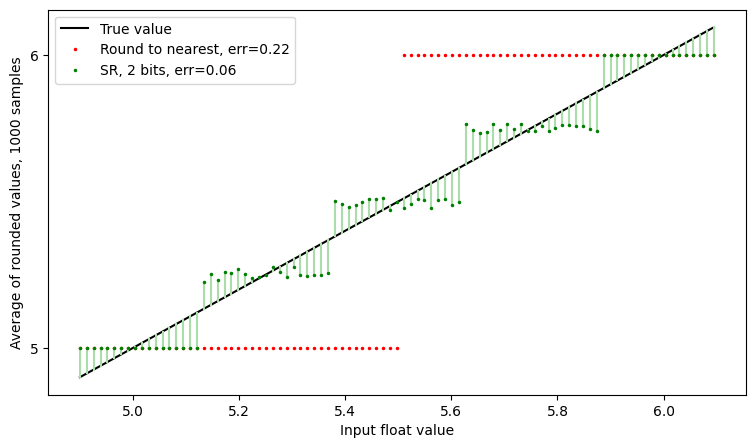

In [5]:
figsize = (9, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.plot(vs, vs, label="True value", color="k")
ax.plot(
    vs,
    rn,
    label=f"Round to nearest, err={err_rn:.2f}",
    color="r",
    markersize=3,
    linestyle="",
    marker=".",
)

# Stochastic rounding
srnumbits = 2
nsamples = 1_000
srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

rvs = round_ndarray(
    fi,
    vs[np.newaxis, :],
    RoundMode.Stochastic,
    sat=False,
    srbits=srbits,
    srnumbits=srnumbits,
)
rvmean = rvs.mean(axis=0)
err = np.abs(rvmean - vs).mean()
lollipops(
    ax,
    vs,
    rvmean,
    key=RoundMode.Stochastic,
    label=f"SR, {srnumbits} bits, err={err:.2f}",
)

ax.set_xlabel("Input float value")
ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
ax.set_yticks(np.unique(rn))
ax.legend()
None

We still have the green line is closer to the black Y=X line than the grey line is,
but now we all see the clear step effect, due to the limited number of SR bits.

As a mental shorthand, we might consider that SR has given us extra precision 
corresponding to the number of `srbits`.
Here, with `srbits = 2`, it's as if we are performing round-to-nearest in a 10-bit 
P5 format rather than an 8-bit P3 one.  Let's just quickly simulate that.
We will make a format like `format_info_ocp_e5m2`, but increase the 
bitwidth and precision:


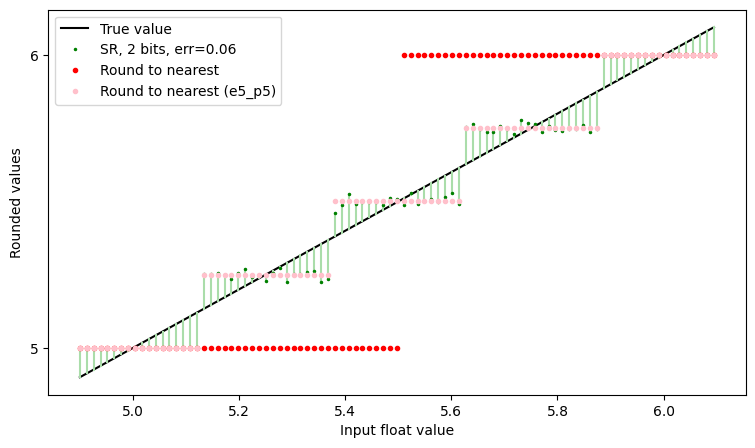

In [6]:
# Make FormatInfo for a putative P5 format with the same exponent range as E5M2
fi_p5 = FormatInfo(
    name="e5_p5",
    k=10,
    precision=5,
    emax=15,
    has_nz=True,
    has_infs=True,
    num_high_nans=2**4 - 1,
    has_subnormals=True,
    is_signed=True,
    is_twos_complement=False,
)

# Round to nearest in P5
rn_p5 = round_ndarray(fi_p5, vs)

fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.plot(vs, vs, label="True value", color="k")

# Stochastic rounding
srnumbits = 2
nsamples = 1_000
srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

rvs = round_ndarray(
    fi,
    vs[np.newaxis, :],
    RoundMode.Stochastic,
    sat=False,
    srbits=srbits,
    srnumbits=srnumbits,
)
rvmean = rvs.mean(axis=0)
err = np.abs(rvmean - vs).mean()
lollipops(
    ax,
    vs,
    rvmean,
    key=RoundMode.Stochastic,
    label=f"SR, {srnumbits} bits, err={err:.2f}",
)

ax.plot(vs, rn, label=f"Round to nearest", color="red", linestyle="", marker=".")
ax.plot(
    vs,
    rn_p5,
    label=f"Round to nearest ({fi_p5})",
    color="pink",
    linestyle="",
    marker=".",
)
ax.set_xlabel("Input float value")
ax.set_ylabel(f"Rounded values")
ax.set_yticks(np.unique(rn))
ax.legend()
None

And we can observe that the "Round to nearest (e5_p5)" line and the "SR" line follow each other, up to noise.
That is, with enough samples, 2 bits of stochastic rounding can be thought of as being
akin to having 2 extra bits of precision.

## Implementation of SR

The second part of this notebook goes deeper into the implementation of SR,
and explores some subtleties that are not generally brought out in discussions of practical implementations.  These subtleties might be summarized as

> stochastic rounding of infinite-precision values with real-valued random variables is easy, 
> but rounding finite-precision values with limited-precision random variables can have surprising effects

Note that these details are independent of the quality of the random number generator (RNG) &mdash; all of the issues discussed here happen with perfect RNGs.

### Case 0: Infinite-precision inputs and real-valued random variables

To begin our discussion, let's start with "high-school" rounding,
where we implement round-to-nearest with code like
```py
def round(x):
  return floor(x + 0.5)
```

Then SR is easily motivated by replacing "0.5" with a random number between 0 and 1:
```py
def round_stochastic(x):
  return floor(x + rand())
```

This is a correct definition when `x` and `rand()` work in infinite precision, 
but needs to change subtly when they are supplied in fixed precision, as is true 
in a floating point system.
  
### Case 1: Infinite-precision inputs and limited-precision random variables

Let's assume that `rand()` produces only `S` bits of randomness at every call,
i.e. that its implementation is something like
```py
def rand(S):
  bits = randint(2**S) # Draw a random S-bit integer (assume this is perfectly random)
  return bits * 2**-S # Return a float in [0, 1)
```
so that SR looks like:
```py
def round_stochastic(x):
  bits = randint(2**S) # Draw a random S-bit integer
  return floor(x + bits * 2**-S)
```
This is essentially gfloat's `StochasticFastest` implementation.
There's a hint in the name "Fastest" that we may be trading speed for accuracy,
so let's see how it behaves, by plotting the mean rounded value for a densely sampled set of inputs, as we did above for our default implementation.

But first, let's look at the actual code to confirm that this is the implementation

In [7]:
# Show the code from gfloat.round_float
import inspect
from more_itertools import one

src = inspect.getsource(round_ndarray).split("\n")
loc = one(
    [i for i, line in enumerate(src) if "case RoundMode.StochasticFastest" in line]
)
print(*src[loc : loc + 3], sep="\n")

        case RoundMode.StochasticFastest:
            assert srbits is not None
            should_round_away = delta > srbits * 2.0**-srnumbits


And now test SRFastest..

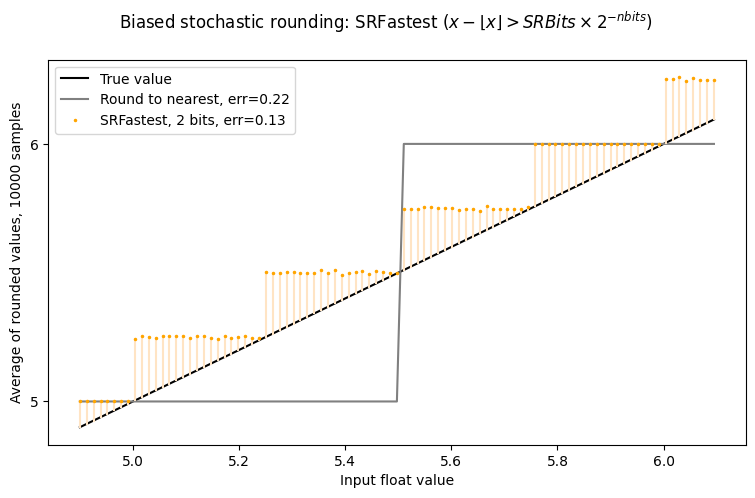

In [8]:
fi = format_info_ocp_e5m2

fig, ax = plt.subplots(1, 1, figsize=figsize)
fig.suptitle(f"Biased stochastic rounding: {longstr(RoundMode.StochasticFastest)}")

ax.plot(vs, vs, label="True value", color="k")
ax.plot(vs, rn, label=f"Round to nearest, err={err_rn:.2f}", color="gray")

# Stochastic rounding
srnumbits = 2
nsamples = 10_000
srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

rvs = round_ndarray(
    fi,
    vs[np.newaxis, :],
    RoundMode.StochasticFastest,
    sat=False,
    srbits=srbits,
    srnumbits=srnumbits,
)
rvmean = rvs.mean(axis=0)
err = np.abs(rvmean - vs).mean()
lollipops(
    ax,
    vs,
    rvmean,
    key=RoundMode.StochasticFastest,
    label=f"{RoundMode.StochasticFastest}, {srnumbits} bits, err={err:.2f}",
)

ax.set_xlabel("Input float value")
ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
ax.set_yticks(np.unique(rn))
ax.legend()
None

Yikes!  The SRFastest line is not symmetric around $Y=X$ -- there is a bias towards positive values.
Note that it is still rounding as if to two extra bits of precision,
but there is a clearly undesirable bias.

Shortly, we will introduce a tool to analyse this more carefully, but for the moment, let's just try a single set of roundings, without averaging:

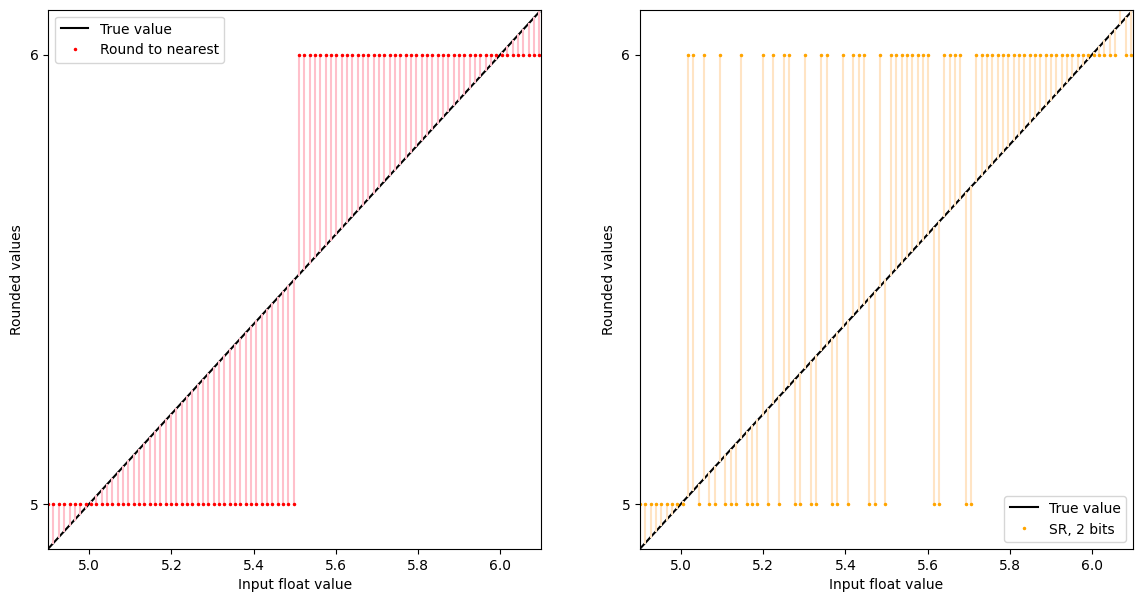

In [9]:
# Stochastic rounding
np.random.seed(1)
srnumbits = 2
srbits = np.random.randint(0, 2**srnumbits, len(vs))
rvs = round_ndarray(
    fi, vs, RoundMode.StochasticFastest, sat=False, srbits=srbits, srnumbits=srnumbits
)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
for ax in axs:
    ax.plot(vs, vs, label="True value", color="k")

    if ax == axs[0]:
        lollipops(ax, vs, rn, key=RoundMode.TiesToEven, label="Round to nearest")
    else:
        lollipops(
            ax, vs, rvs, key=RoundMode.StochasticFastest, label=f"SR, {srnumbits} bits"
        )

    ax.set_xlabel("Input float value")
    ax.set_ylabel(f"Rounded values")
    ax.set_yticks(np.unique(rvs))
    ax.set_xlim(4.9, 6.1)
    ax.set_ylim(4.9, 6.1)
    ax.legend()

Yes, it looks as if there are more roundings-up than roundings-down, consistent with the averages we saw above.

### Rounding profiles: a tool to understand the bias 

To visualize the behaviour of a conventional rounding mode, we might
plot the rounding for a densely sampled set of values between two floats.

In OCP E5M2 format, the values 5 and 6 are adjacent floats.  Under NearestTiesToEven,
all values between them below 5.5 round to 5, the other values to 6.

We would express this behaviour as a "rounding profile" a function from the reals to 
the value set of the floating point format. 

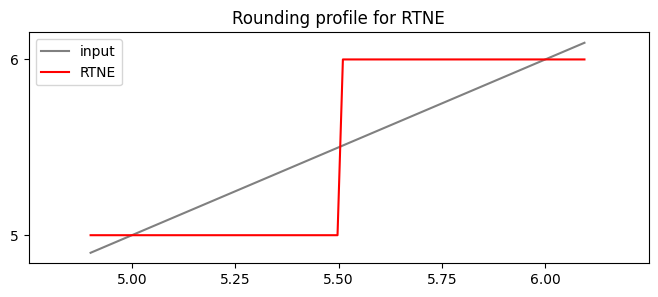

In [10]:
fig, ax = plt.subplots(figsize=(8, 3))
r = round_ndarray(fi, vs, RoundMode.TiesToEven)
ax.plot(vs, vs, label=f"input", color="gray")
ax.plot(vs, r, label=f"RTNE", color=mode_colors[RoundMode.TiesToEven][1])
ax.set_xlim(4.75, 6.25)
ax.set_xticks(np.arange(5, 6.1, step=0.25))
ax.set_yticks([5, 6])
ax.legend()
ax.set_title(f"Rounding profile for RTNE")
None

To consider the behaviour of stochastic rounding, think of it as selecting a random 
rounding profile based on the set of stochastic rounding bits.  Let us plot those 
profiles for SRNumBits=2, so there are four profiles.

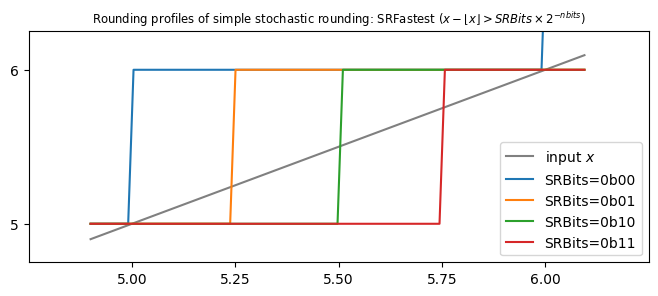

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(vs, vs, label=f"input $x$", color="gray")

srnumbits = 2
for srbits in range(2**srnumbits):
    r = round_ndarray(
        fi,
        vs,
        RoundMode.StochasticFastest,
        sat=False,
        srbits=np.full(vs.shape, srbits),
        srnumbits=srnumbits,
    )
    ax.plot(vs, r, label=f"SRBits=0b{srbits:02b}")
ax.set_xlim(4.75, 6.25)
ax.set_ylim(4.75, 6.25)
ax.set_xticks(np.arange(5, 6.1, step=0.25))
ax.set_yticks([5, 6])
ax.legend()
ax.set_title(
    f"Rounding profiles of simple stochastic rounding: {longstr(RoundMode.StochasticFastest)}",
    fontsize="small",
)
None

So, if SRBits = 0b01, then any value above 5.25 is rounded to 6, which feels sensible;
and if SRBits = 0b11, then any value above 5.75 rounds to 6, again sensible.

But look what happens if SRBits = 0b00.  Then any value above 5.0 rounds to 6.0, which 
feels a bit wasteful.  If we look at the list of step thresholds:
```python
  [5.00, 5.25, 5.50, 5.75]
```
we could make them more symmetric by adding 1/8 to each:
```python
  [5.125, 5.375, 5.625, 5.875]
```

Put more generally, we will add an extra half bit to SRBits.

From:
```py
def round_stochastic_fastest(x):
  bits = randint(2**S) # Draw a random S-bit integer
  return floor(x + bits * 2**-S)
```

To:
```py
def round_stochastic_fast(x):
  bits = randint(2**S) # Draw a random S-bit integer
  return floor(x + (bits + 0.5) * 2**-S)
```

This is essentially what is done in the mode called `RoundMode.StochasticFast`.
Let's see if it works...

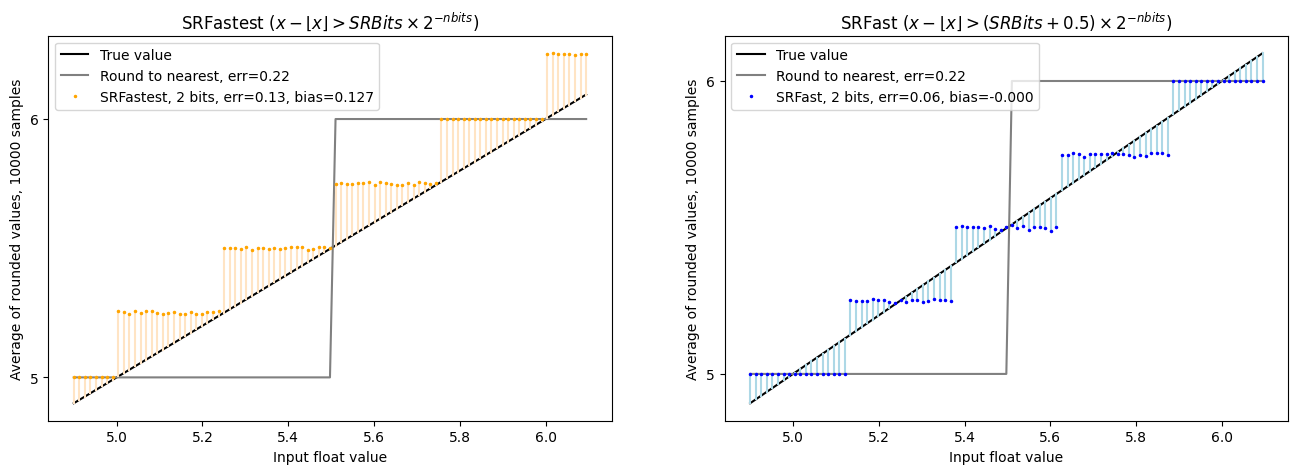

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

for rnd, ax in zip((RoundMode.StochasticFastest, RoundMode.StochasticFast), axs):
    ax.plot(vs, vs, label="True value", color="k")
    ax.plot(vs, rn, label=f"Round to nearest, err={err_rn:.2f}", color="gray")

    # Stochastic rounding
    srnumbits = 2
    nsamples = 10_000
    srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

    rvs = round_ndarray(
        fi, vs[np.newaxis, :], rnd, sat=False, srbits=srbits, srnumbits=srnumbits
    )
    rvmean = rvs.mean(axis=0)
    err = np.abs(rvmean - vs).mean()
    bias = (rvmean - vs).mean()

    label = f"{rnd}, {srnumbits} bits, err={err:.2f}, {bias=:.3f}"
    lollipops(ax, vs, rvmean, key=rnd, label=label)

    ax.set_title(longstr(rnd))
    ax.set_xlabel("Input float value")
    ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
    ax.set_yticks(np.unique(rn))
    ax.legend()

Good news. `SRFast` seems to have fixed things...
What could be wrong?  Why is that not the default?

### Case 2: Finite-precision inputs and limited-precision random variables

The answer is that we are still modelling the inputs `v` as being infinite precision (well, they are float64 here, but that's pretty much infinite precision).

If we first assume that they are available in some finite precision, 
still larger than that to which we are effectively rounding, then we obtain another, relatively small, bias.

Let's add some lines to the above...

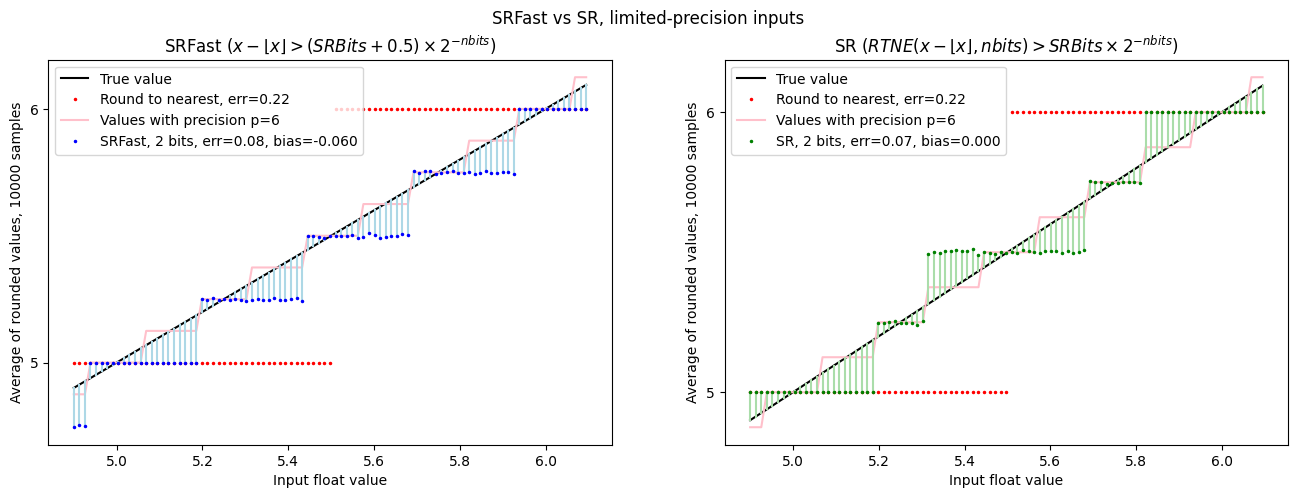

In [13]:
# Make FormatInfo for a putative E5M6 format
highp = fi.precision + 3
fi_p9 = FormatInfo(
    name=f"e5m{highp-1}",
    k=5 + highp,
    precision=highp,
    emax=15,
    has_nz=True,
    has_infs=True,
    num_high_nans=2 ** (highp - 1) - 1,
    has_subnormals=True,
    is_signed=True,
    is_twos_complement=False,
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("SRFast vs SR, limited-precision inputs")

for rnd, ax in zip((RoundMode.StochasticFast, RoundMode.Stochastic), axes):
    ax.plot(vs, vs, label="True value", color="k")
    ax.plot(
        vs,
        rn,
        label=f"Round to nearest, err={err_rn:.2f}",
        color="red",
        markersize=3,
        linestyle="",
        marker=".",
    )

    # Stochastic rounding
    srnumbits = 2
    nsamples = 10_000
    srbits = np.random.randint(0, 2**srnumbits, (nsamples, len(vs)))

    # The infinite-precision vs, but computed to `highp` bits of precision
    vs_p9 = round_ndarray(fi_p9, vs, RoundMode.TiesToEven)

    ax.plot(vs, vs_p9, label=f"Values with precision p={fi_p9.precision}", color="pink")

    rvs = round_ndarray(
        fi, vs_p9[np.newaxis, :], rnd, sat=False, srbits=srbits, srnumbits=srnumbits
    )
    rvmean = rvs.mean(axis=0)
    err = np.abs(rvmean - vs).mean()
    bias = (rvmean - vs).mean()

    label = f"{rnd}, {srnumbits} bits, {err=:.2f}, {bias=:.3f}"
    lollipops(ax, vs, rvmean, label=label, key=rnd)

    ax.set_xlabel("Input float value")
    ax.set_ylabel(f"Average of rounded values, {nsamples} samples")
    ax.set_yticks(np.unique(rn))
    ax.legend()
    ax.set_title(f"{longstr(rnd)}")

So...  The `SRFast` curve now shows some bias: the dots are generally below the Y=X line.
The `SR` curve is now unbiased, but shows a peculiar non-coherence in terms of the widths 
of the plateaus.  To explain this, recall the "rounding profiles" above.
With only two bits of randomness, we can have only four rounding profiles.
Those profiles must have their steps coinciding with the steps in the "Values with precision p=6" 
curve, so in order to be symmetric, the central region must be either one or three units wide,
and the adjacent steps must be three or one wide.
That choice of "three or one" depends on whether the implementation rounds to 
nearest even or odd before comparing to SRbits.

Let's plot all the rounding profiles together:

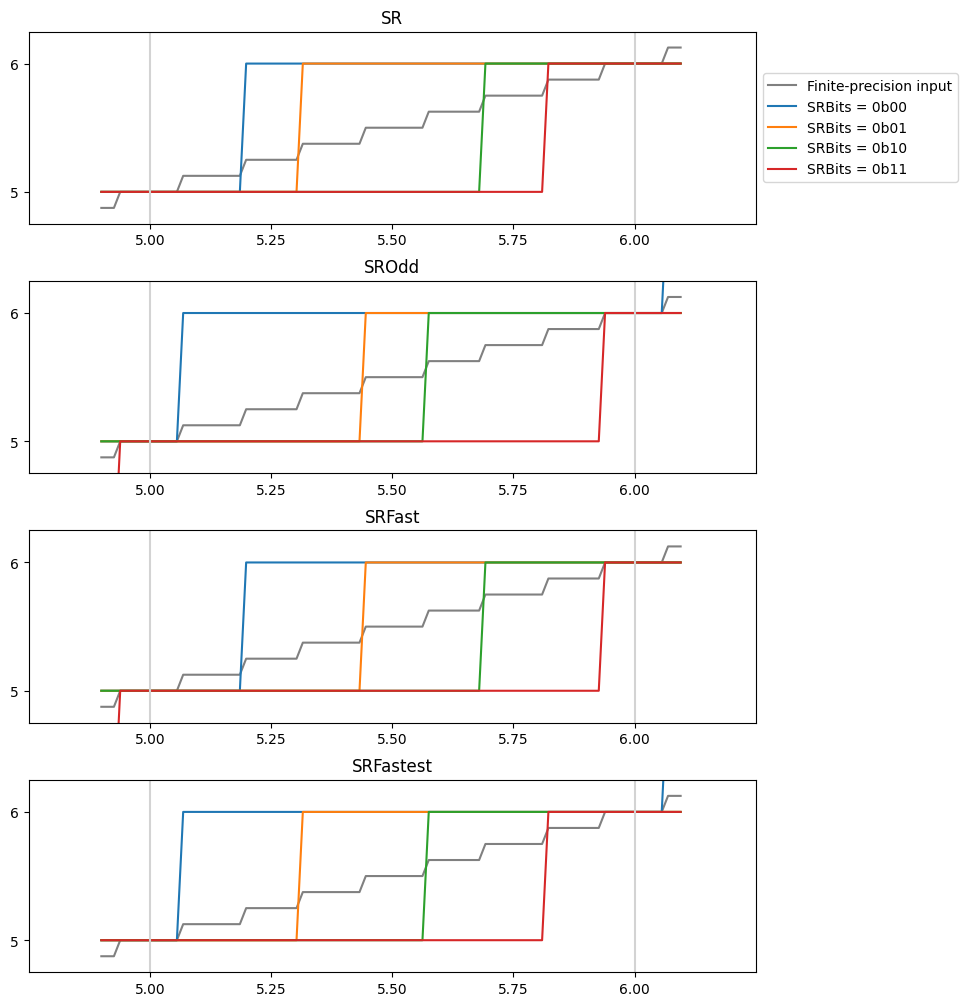

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(8, 10))
fig.tight_layout(h_pad=2)
h = 0.7
for rnd, ax in zip(
    (
        RoundMode.Stochastic,
        RoundMode.StochasticOdd,
        RoundMode.StochasticFast,
        RoundMode.StochasticFastest,
    ),
    axs,
):
    # The infinite-precision vs, but computed to `highp` bits of precision
    vs_p9 = round_ndarray(fi_p9, vs, RoundMode.TiesToEven)

    ax.plot(vs, vs_p9, label=f"Finite-precision input", color="gray")

    srnumbits = 2
    for srbits in range(2**srnumbits):
        r = round_ndarray(
            fi,
            vs_p9,
            rnd,
            sat=False,
            srbits=np.full(vs.shape, srbits),
            srnumbits=srnumbits,
        )
        ax.plot(vs, r, label=f"SRBits = 0b{srbits:02b}")
    for k in (5, 6, 7):
        ax.plot([k, k], [0, 10], color="lightgray", linestyle="-")
    ax.set_xlim(4.75, 6.25)
    ax.set_ylim(4.75, 6.25)
    ax.set_xticks(np.arange(5.0, 6.1, step=0.25))
    ax.set_yticks([5, 6])
    if ax == axs[0]:
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(f"{rnd}")
None

## Conclusion

Stochastic rounding provides a pretty impressive approximation of higher precision
when casting high-precision values to lower precision.  However, it comes at the 
cost that the number of random bits used per cast should match the input precision.
The number of random bits can be reduced, but care must be taken to ensure that doing
so does not introduce a bias.  Fortunately, mitigations are available, as implemented 
in this library.  We don't know the details of the various hardware implementations of 
SR, but we also know of no description of these biases in the current literature.

Conversely, it might be that in some use-cases, a bias is advantageous.
For example, adding gradient updates in a stochastic optimizer - it may be that it's 
always a good idea to make *some* change, as it can be undone in the reverse direction
on the following iteration.  But that is speculation - let's see how people use these
ideas in practice.
